In [61]:
import torch 
import torch.nn as nn

In [62]:
class ACNet(nn.Module):
    def __init__(self,q,dt):
        self.lay = 200
        super(ACNet,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, self.lay),
            nn.Tanh(),
            nn.Linear( self.lay, self.lay),
            nn.Tanh(),
            nn.Linear( self.lay, self.lay),
            nn.Tanh(),
            nn.Linear( self.lay, self.lay),
            nn.Tanh(),
            nn.Linear( self.lay,q+1)
        )
        tmp = np.float32(np.loadtxt('Utilities/IRK_weights/Butcher_IRK%d.txt' % (q), ndmin = 2))
        self.IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q))
        self.IRK_times = tmp[q**2+q:]
        self.dt = dt

    def forward(self, x):
        x = self.net(x)
        return x

    # loss function
    def MSE(self,ypred,ytrue):
        return torch.mean((ypred - ytrue)**2) 

    # Glorot initialization of weight matrix
    def glorot_init_mat(self,shape):
        din = shape[0]
        dout = shape[1]
        var = torch.tensor([2.0/(din+dout)])
        std = torch.sqrt(var)
        mean = torch.tensor([0.0])
        dist = torch.distributions.normal.Normal(mean, std)
        return dist.sample(shape)
    
    def U_ic(self, x0):
        xc = x0.clone()
        xc.requires_grad = True
        U = self.forward(xc)
        Uc = U[:,:-1]
        Ucx = torch.autograd.grad(Uc.sum(),xc,create_graph=True)[0]
        Ucxx = torch.autograd.grad(Ucx.sum(),xc,create_graph=True)[0]
        F = -0.0001*Ucxx + 5*Uc**3 - 5*Uc
        u0_pred = U - torch.Tensor(self.dt)*F.mm(torch.tensor(self.IRK_weights).transpose(0,1))
        return u0_pred
    
    def U_bc(self, xb):
        xbc = xb.clone()
        xbc.requires_grad = True
        Ub_pred = self.forward(xbc)
        Ub_pred1 = torch.autograd.grad(Ub_pred.sum(),xbc,create_graph=True)[0]
        return Ub_pred, Ub_pred1

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pyDOE import lhs
import argparse
import scipy.io

In [64]:
parser = argparse.ArgumentParser()
parser.add_argument("--epochs", help="Number of epochs to train neural network for")

"""data prep"""
"""
DE: u_t-0.0001*u_{xx}+5*u^3-5*u=0
"""
args = parser.parse_args(['--epochs','50000'])

In [65]:
data = scipy.io.loadmat('Data/AC.mat')
    
t = data['tt'].flatten()[:,None]#T x 1
x = data['x'].flatten()[:,None]# N x 1
Exact = np.real(data['uu'])#N x T

In [66]:
N, q = 200,100
# Doman bounds
lb = np.array([-1.0])
ub = np.array([1.0])

idx_t0 = 20
idx_t1 = 180
dt = t[idx_t1] - t[idx_t0]
# Generate samples for x, t
#sample points
#noise_u0 = 0.0
idx_x = np.random.choice(Exact.shape[0], N, replace=False) 
x0 = x[idx_x,:]
u0 = Exact[idx_x, idx_t0:idx_t0+1]
#u0 = u0 + noise_u0*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])

# Boudanry data
xb = np.vstack((lb,ub))
x_star = x
x_star = torch.tensor(x_star).type(torch.FloatTensor)
u_star = Exact[:, idx_t1:idx_t1+1]

In [67]:

"""NN class, init, loss functions, dataloader"""

# %%
"""training process"""
#Instantiate class
pn = ACNet(q,dt)
# %%
#load u0
u0 = u0.reshape((-1, 1))
u0 = torch.tensor(u0).type(torch.FloatTensor)
# load x, t data into torch
x0 = x0.reshape((-1, 1))
x0 = torch.tensor(x0).type(torch.FloatTensor)

xb = xb.reshape((-1, 1))
xb = torch.tensor(xb).type(torch.FloatTensor)

In [69]:
# %%

#Initialize weights
#Glorot initialization
[W, b] = list(pn.net[0].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[2].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[4].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[6].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[8].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

bb=0

In [70]:
# %%
# Perform backprop
MAX_EPOCHS = int(args.epochs)
LRATE = 3e-4
#LRATE = 0.001

#Use Adam for training
optimizer = torch.optim.Adam(pn.parameters(), lr=LRATE)

loss_history_ic = []
loss_history_bc = []
loss_history = []

In [71]:
import time
start_time = time.time()
for epoch in range(MAX_EPOCHS):
    #full batch

    #initial condition
    u0_pred = pn.U_ic(x0)
    mse_ic = pn.MSE(u0_pred, u0.expand(u0_pred.shape))
    loss_history_ic.append([epoch, mse_ic.item()])
    
    #boundary condition
    Ub_pred, Ub_pred1 = pn.U_bc(xb)
    mse_bc = pn.MSE(Ub_pred[0:1,:], Ub_pred[1:2,:])+ pn.MSE(Ub_pred1[0:1,:], Ub_pred1[1:2,:])
    loss_history_bc.append([epoch, mse_bc.item()])

    loss = mse_ic + mse_bc
    loss_history.append([epoch, loss.item()])

    #optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        print("Epoch: {}, MSE_ic: {:.4f}, MSE_bc: {:.4f},, MSE: {:.4f}".format((epoch+1), mse_ic, mse_bc, loss))
elapsed = time.time() - start_time

Epoch: 1000, MSE_ic: 0.0685, MSE_bc: 0.0000,, MSE: 0.0686
Epoch: 2000, MSE_ic: 0.0632, MSE_bc: 0.0000,, MSE: 0.0632
Epoch: 3000, MSE_ic: 0.0622, MSE_bc: 0.0001,, MSE: 0.0623
Epoch: 4000, MSE_ic: 0.0585, MSE_bc: 0.0000,, MSE: 0.0585
Epoch: 5000, MSE_ic: 0.0584, MSE_bc: 0.0000,, MSE: 0.0585
Epoch: 6000, MSE_ic: 0.0570, MSE_bc: 0.0125,, MSE: 0.0695
Epoch: 7000, MSE_ic: 0.0554, MSE_bc: 0.0000,, MSE: 0.0555
Epoch: 8000, MSE_ic: 0.0559, MSE_bc: 0.0029,, MSE: 0.0588
Epoch: 9000, MSE_ic: 0.0539, MSE_bc: 0.0000,, MSE: 0.0539
Epoch: 10000, MSE_ic: 0.0547, MSE_bc: 0.0003,, MSE: 0.0549
Epoch: 11000, MSE_ic: 0.0553, MSE_bc: 0.0018,, MSE: 0.0570
Epoch: 12000, MSE_ic: 0.0563, MSE_bc: 0.0002,, MSE: 0.0565
Epoch: 13000, MSE_ic: 0.0524, MSE_bc: 0.0000,, MSE: 0.0524
Epoch: 14000, MSE_ic: 0.0539, MSE_bc: 0.0001,, MSE: 0.0540
Epoch: 15000, MSE_ic: 0.0512, MSE_bc: 0.0000,, MSE: 0.0512
Epoch: 16000, MSE_ic: 0.0513, MSE_bc: 0.0000,, MSE: 0.0514
Epoch: 17000, MSE_ic: 0.0508, MSE_bc: 0.0000,, MSE: 0.0508
Epoch:

In [41]:
#%%
#save trained model
fname = "ACNet_{}.pt".format(MAX_EPOCHS)
torch.save(pn, fname)

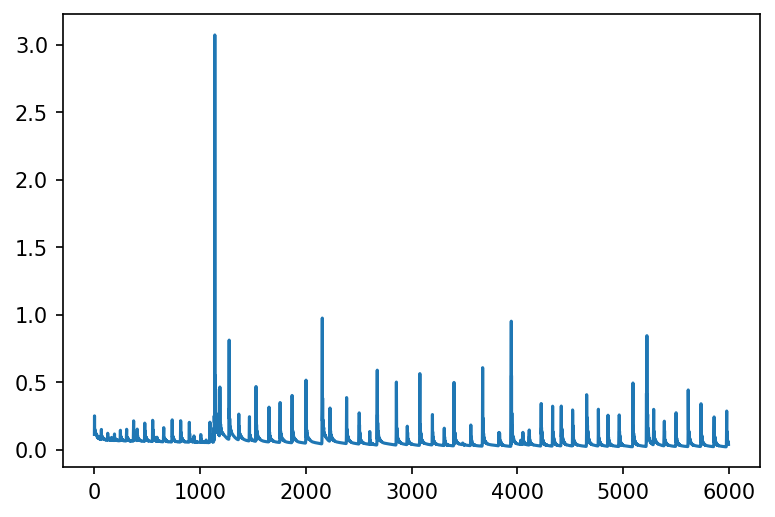

In [42]:
#%%
loss_history = np.array(loss_history)
plt.figure(dpi=150)
plt.plot(loss_history[0:6000,0], loss_history[0:6000,1])
plt.savefig("ACNet_loss_hist_{}.png".format(MAX_EPOCHS))
#plt.show()

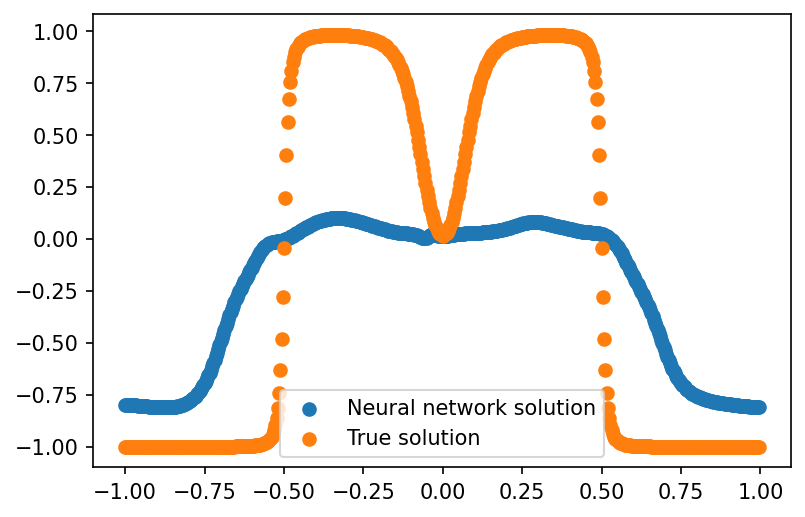

In [44]:
#%%
plt.figure(dpi=150)
u1_pred = pn.U_ic(x_star)
u1_pred = u1_pred[:,0:1]
plt.scatter(x1.data.numpy(), u1_pred.data.numpy(), label="Neural network solution")
plt.scatter(x1.data.numpy(), u_star, label="True solution")
plt.legend()
#plt.savefig("PINN_soln_comp_{}.png".format(N_f))
#plt.show()

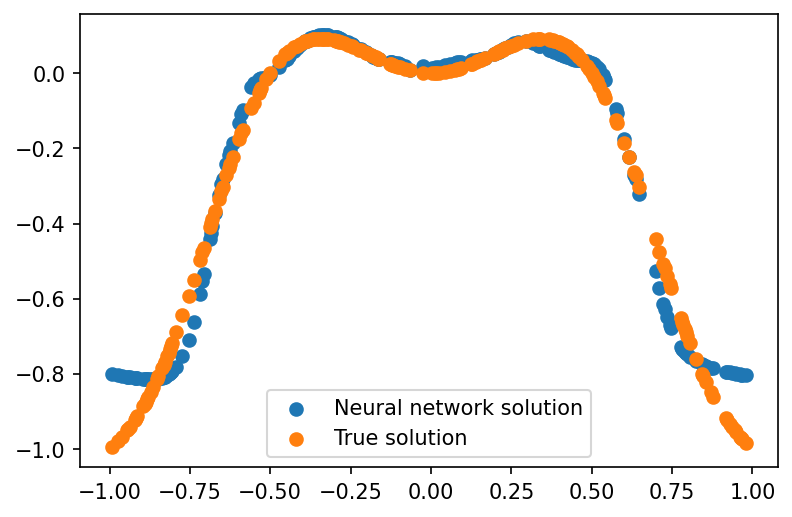

In [45]:
#%%
plt.figure(dpi=150)

plt.scatter(x0.data.numpy(), u0_pred[:,0:1].data.numpy(), label="Neural network solution")
plt.scatter(x0.data.numpy(), u0, label="True solution")
plt.legend()
#plt.savefig("PINN_soln_comp_{}.png".format(N_f))
#plt.show()